#########################
# Regression logistique #
#########################


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

data = pd.read_csv("heart_cleveland.csv")
X = data.drop('condition', axis = 1)
Y = data.condition

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(y_train.mean())
print(y_test.mean())# 

SK_logit = LogisticRegression(max_iter =2000, penalty=None)
# Attention a la pénalité
SK_logit.fit(X_train, y_train)

SK_logit.intercept_.reshape(1,1).shape


0.46835443037974683
0.43333333333333335


(1, 1)

In [12]:
# Estimation des parametres avec l'intercept
pd.DataFrame(np.concatenate([SK_logit.intercept_.reshape(1,1),
                              SK_logit.coef_],axis=1),index = ["coef"],columns = ["constante"]+list(X.columns))

# Estimation des odds ratios
params = SK_logit.coef_
pd.DataFrame(np.exp(params),
             index = ["coef"],
             columns = list(X.columns)).T


,coef
age,0.973960
trestbps,1.027350
chol,1.002556
thalach,0.979982
oldpeak,1.290125
cp,1.915221
exang,1.912735
slope,1.943859
ca,3.559736
thal,2.507389


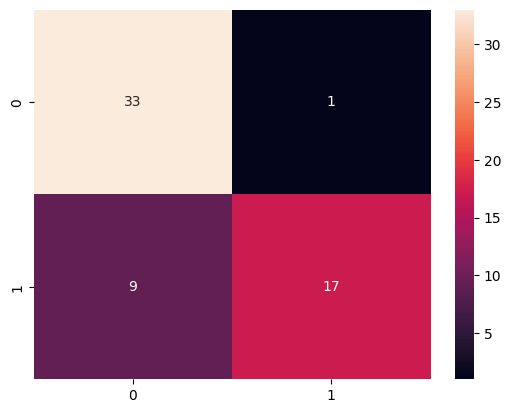

In [13]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(y_test, SK_logit.predict(X_test))
pd.DataFrame(conf, index =['true 0', 'true 1'], columns = ['pred 0', 'pred 1'])
plt.figure()
sns.heatmap(conf, annot=True)
plt.show()


In [14]:
# Pour obtenir les IC et tests
import statsmodels.api as sm
# on ajoute une colonne pour la constante
x_stat = sm.add_constant(X_train)
# on ajuste le modèle
model = sm.Logit(y_train, x_stat)
result = model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.351322
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              condition   No. Observations:                  237
Model:                          Logit   Df Residuals:                      226
Method:                           MLE   Df Model:                           10
Date:                Tue, 25 Nov 2025   Pseudo R-squ.:                  0.4917
Time:                        23:35:31   Log-Likelihood:                -83.263
converged:                       True   LL-Null:                       -163.80
Covariance Type:            nonrobust   LLR p-value:                 1.944e-29
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.8119      2.736     -1.393      0.164      -9.175       1.551
age           -0.0264      0.

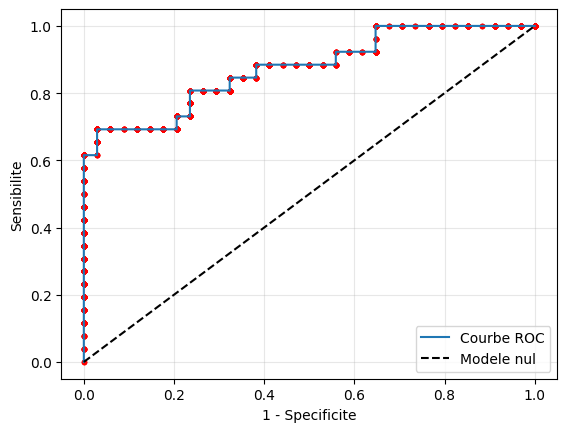

In [15]:
# Courbe ROC
prob = SK_logit.predict_proba(X_test)[:, 1]
thresholds = np.arange(1, 4001) / 4000.0
err = []
TP = []
VN = []

for s in thresholds:
    Y_pred = prob > s
    # ensure a 2x2 confusion matrix in the order [0,1]
    conf = confusion_matrix(y_test, Y_pred,labels=[0, 1])
    # conf layout: [[TN, FP],
    #               [FN, TP]]
    err.append(conf[0, 1] + conf[1, 0])
    TP.append(conf[1, 1])
    VN.append(conf[0, 0])

err = np.array(err, dtype=float)/y_test.size
TP = np.array(TP, dtype=float)/sum(y_test)
FP = 1-np.array(VN, dtype=float)/(y_test.size-sum(y_test))

plt.figure()
plt.plot(FP[::-1], TP[::-1], 'r.')
plt.step(FP[::-1], TP[::-1],where='pre',label='Courbe ROC')
plt.plot([0, 1], [0, 1], 'k--',label='Modele nul')
plt.xlabel('1 - Specificite')
plt.ylabel('Sensibilite')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


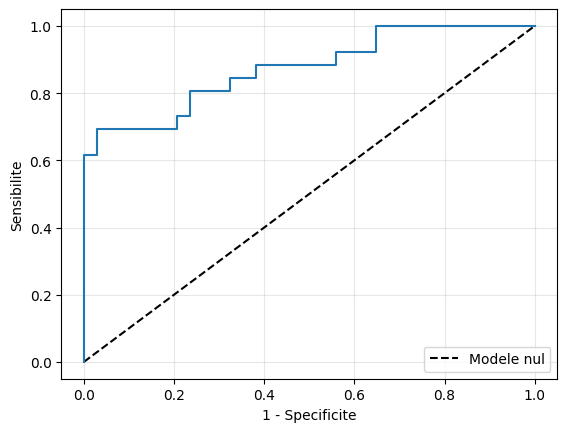

In [16]:
# Meme chose avec le package AUC
from sklearn.metrics import roc_curve, auc    

fpr0, tpr0, thresholds0 = roc_curve(y_test, prob, drop_intermediate=False)

plt.figure()
plt.plot([0, 1], [0, 1], 'k--',label='Modele nul')
plt.plot(fpr0, tpr0)
plt.grid(alpha=0.3)
plt.xlabel('1 - Specificite')
plt.ylabel('Sensibilite')
plt.legend(loc='lower right')
plt.show()
